In [ ]:
# K-Means Clustering on Movie Features

# Import necessary libraries
import os
import json
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN, NearestNeighbour
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Set plotting style
sns.set(style='whitegrid')

# Constants
DATA_PATH = "../data"
NETFLIX_FOLDER_PATH = os.path.join(DATA_PATH, "netflix_prize")
IMDB_FOLDER_PATH = os.path.join(DATA_PATH, "imdb")
MIN_OCCURRENCES = 20


In [67]:
# Load feature mapping
feature_mapping_path = os.path.join(DATA_PATH, f"processed/feature_mapping_{MIN_OCCURRENCES}.pickle")
with open(feature_mapping_path, 'rb') as f:
    feature_mapping = pickle.load(f)

# Load movie features
movie_features_path = os.path.join(DATA_PATH, f"processed/movie_features_{MIN_OCCURRENCES}.pickle")
with open(movie_features_path, 'rb') as f:
    movie_features = pickle.load(f)

# Load movie titles
movie_titles_path = os.path.join(NETFLIX_FOLDER_PATH, 'movie_titles.txt')

# Create a mapping from movie_id to movie_title
movie_titles = {}

with open(movie_titles_path, 'r', encoding='ISO-8859-1') as f:
    for line in f:
        parts = line.strip().split(',', 2)  # Split into 3 parts: id, year, title
        if len(parts) == 3:
            movie_id, year, title = parts
            movie_titles[movie_id] = title
        else:
            # Handle possible missing data
            print(f"Warning: line not in expected format: {line}")

## Preprocess

In [68]:
# Get list of all feature IDs
feature_ids = list(feature_mapping['id_to_feature'].keys())

# Get list of all movie IDs
movie_ids = list(movie_features.keys())

# Initialize a DataFrame with zeros
data = pd.DataFrame(0, index=movie_ids, columns=feature_ids)

# Fill the DataFrame with movie features
for movie_id, features in movie_features.items():
    data.loc[movie_id, features] = 1

## K-Means Clustering

In [69]:
# Range of k values
range_n_clusters = range(2, 21)

# Lists to store evaluation metrics
silhouette_scores = []
calinski_harabasz_scores = []

# Perform clustering and compute metrics
for n_clusters in range_n_clusters:
    # Initialize KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    
    # Compute Silhouette Score
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Compute Calinski-Harabasz Index
    ch_score = calinski_harabasz_score(data, cluster_labels)
    calinski_harabasz_scores.append(ch_score)

### Plot Metrics Over k

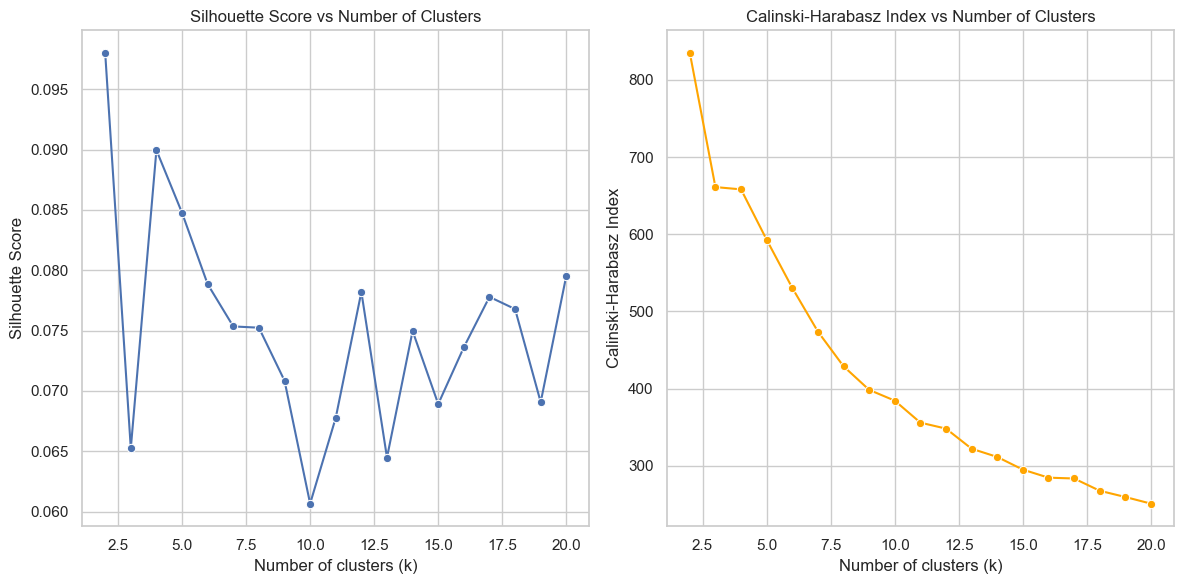

In [70]:
# Plotting the metrics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

plt.figure(figsize=(12, 6))

# Silhouette Score plot
plt.subplot(1, 2, 1)
sns.lineplot(x=list(range_n_clusters), y=silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

# Calinski-Harabasz Index plot
plt.subplot(1, 2, 2)
sns.lineplot(x=list(range_n_clusters), y=calinski_harabasz_scores, marker='o', color='orange')
plt.title('Calinski-Harabasz Index vs Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')

plt.tight_layout()
plt.show()

### Comparison of Silhouette Score and Calinski-Harabasz on a normalized scatter plot.
- also determines that the optimal k is 2.

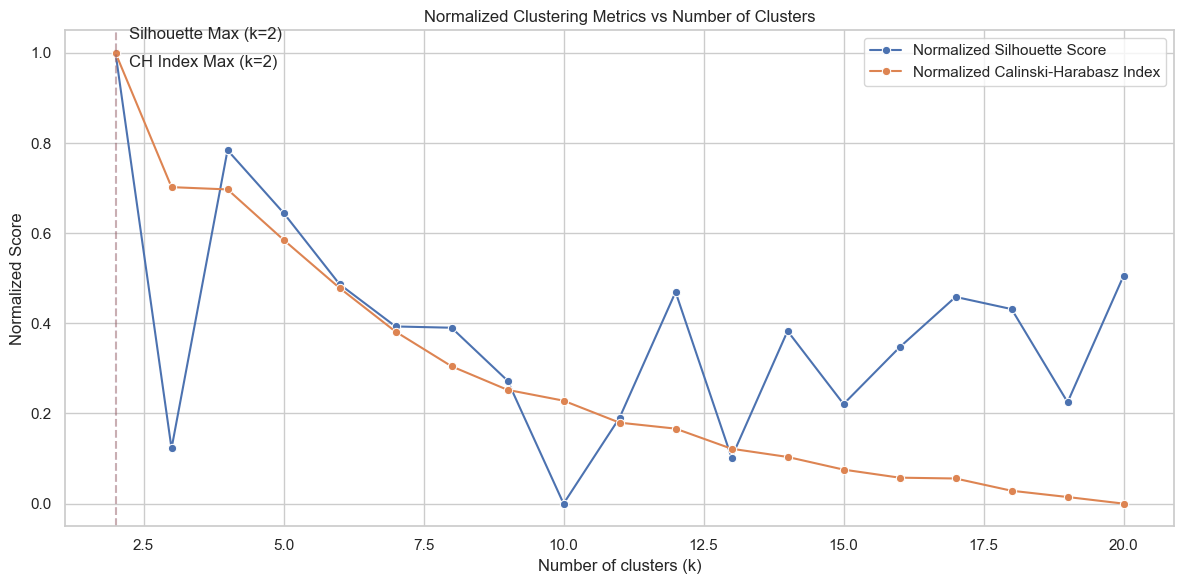

Optimal k according to Silhouette Score: 2
Optimal k according to Calinski-Harabasz Index: 2
Optimal k must be 2


In [71]:
# Normalize the metrics to a 0-1 scale
silhouette_normalized = (silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))
ch_normalized = (calinski_harabasz_scores - np.min(calinski_harabasz_scores)) / (np.max(calinski_harabasz_scores) - np.min(calinski_harabasz_scores))

# Create the combined plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=list(range_n_clusters), y=silhouette_normalized, marker='o', label='Normalized Silhouette Score')
sns.lineplot(x=list(range_n_clusters), y=ch_normalized, marker='o', label='Normalized Calinski-Harabasz Index')

# Add vertical lines at the maximum points
silhouette_max_k = range_n_clusters[np.argmax(silhouette_normalized)]
ch_max_k = range_n_clusters[np.argmax(ch_normalized)]

plt.axvline(x=silhouette_max_k, color='blue', linestyle='--', alpha=0.3)
plt.axvline(x=ch_max_k, color='orange', linestyle='--', alpha=0.3)

# Customize the plot
plt.title('Normalized Clustering Metrics vs Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Normalized Score')
plt.grid(True)
plt.legend()

# Add annotations for maximum points
plt.annotate(f'Silhouette Max (k={silhouette_max_k})', 
            xy=(silhouette_max_k, 1), 
            xytext=(10, 10),
            textcoords='offset points')
plt.annotate(f'CH Index Max (k={ch_max_k})', 
            xy=(ch_max_k, 1), 
            xytext=(10, -10),
            textcoords='offset points')

plt.tight_layout()
plt.show()

best_k = range_n_clusters[np.argmax(silhouette_scores)]

# Print the optimal k values
print(f"Optimal k according to Silhouette Score: {silhouette_max_k}")
print(f"Optimal k according to Calinski-Harabasz Index: {ch_max_k}")
print (f"Optimal k must be {best_k}")

In [72]:
# Perform KMeans clustering with the optimal k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(data)

# Add cluster labels to the DataFrame
data['Cluster'] = cluster_labels

### Visualize in 2D

PCA

In [73]:
# Perform PCA
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(data.drop('Cluster', axis=1))

# Create a DataFrame for plotting
plot_data = pd.DataFrame()
plot_data['PC1'] = data_pca[:, 0]
plot_data['PC2'] = data_pca[:, 1]
plot_data['Cluster'] = cluster_labels
plot_data['MovieID'] = data.index

Create Legend

In [74]:
# Map MovieID to MovieName
plot_data['MovieName'] = plot_data['MovieID'].map(movie_titles)

# Map feature IDs to feature names
id_to_feature = feature_mapping['id_to_feature']

# Function to get feature names for a movie
def get_feature_names(movie_id):
    feature_ids = movie_features.get(movie_id, [])
    feature_names = [id_to_feature[feature_id] for feature_id in feature_ids]
    return ', '.join(feature_names)

# Add FeatureNames to plot_data
plot_data['FeatureNames'] = plot_data['MovieID'].apply(get_feature_names)

In [75]:
# Prepare the data
plot_data['Cluster'] = plot_data['Cluster'].astype(str)  # Convert cluster labels to strings for color encoding

# Create an interactive Plotly scatter plot
fig = px.scatter(
    plot_data,
    x='PC1',
    y='PC2',
    color='Cluster',
    hover_data={
        'MovieID': True,
        'MovieName': True,
        'FeatureNames': True,
        'Cluster': False,
        'PC1': False,
        'PC2': False
    },
    title=f'K-Means Clustering of Movies (k={best_k})',
    width=800,
    height=600
)

# Update layout for better visuals
fig.update_layout(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    legend_title='Cluster',
    legend=dict(itemsizing='constant')
)

# Show the figure
fig.show()

# DBScan

### Data Preparation 

In [76]:
feature_ids = list(feature_mapping['id_to_feature'].keys())
movie_ids = list(movie_features.keys())

# Initialize and fill the DataFrame
data = pd.DataFrame(0, index=movie_ids, columns=feature_ids)
for movie_id, features in movie_features.items():
    data.loc[movie_id, features] = 1

### Parameter Optimization Functions

In [77]:
def find_elbow_point(distances):
    """Find the elbow point using local maxima of curvature"""
    gradient = np.gradient(distances)
    curvature = np.gradient(gradient)
    elbow_idx = argrelextrema(curvature, np.greater)[0]
    if len(elbow_idx) > 0:
        return distances[elbow_idx[0]]
    return np.median(distances)

## Calculate K-distance Graphs and Find Optimal Parameters

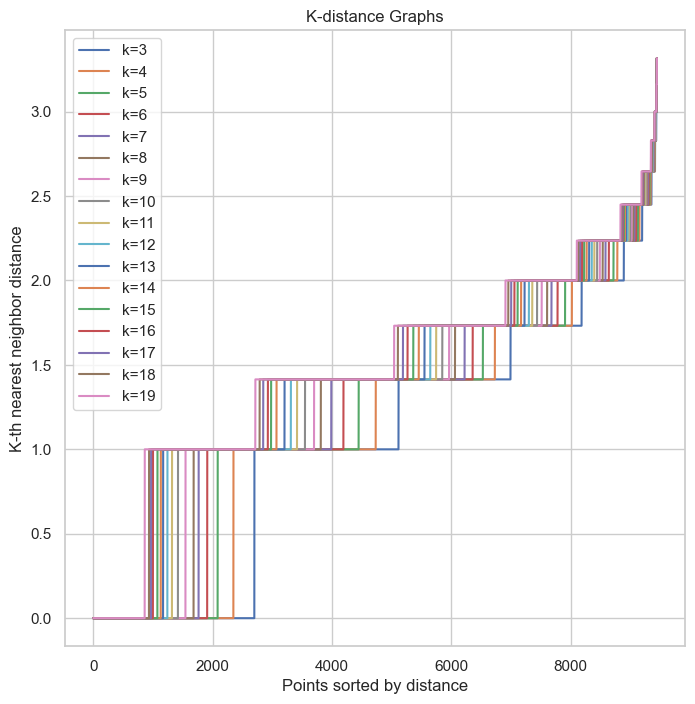

In [91]:
# Calculate proper min_samples range based on dimensionality
from sklearn.neighbors import NearestNeighbors

D = len(feature_ids)
min_samples_range = range(3, min(2 * D, 20))

# Calculate k-distance graph for each min_samples value
plt.figure(figsize=(8, 8))
eps_values = []

for k in min_samples_range:
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    distances_k = np.sort(distances[:, -1])
    eps_values.append(find_elbow_point(distances_k))
    plt.plot(distances_k, label=f'k={k}')

plt.title('K-distance Graphs')
plt.xlabel('Points sorted by distance')
plt.ylabel('K-th nearest neighbor distance')
plt.legend()

*Diagram Notes*:
- Points at 1.0, 1.4 and 2.0 are good values for epsilon?

## Evaluate Different Parameter Combinations

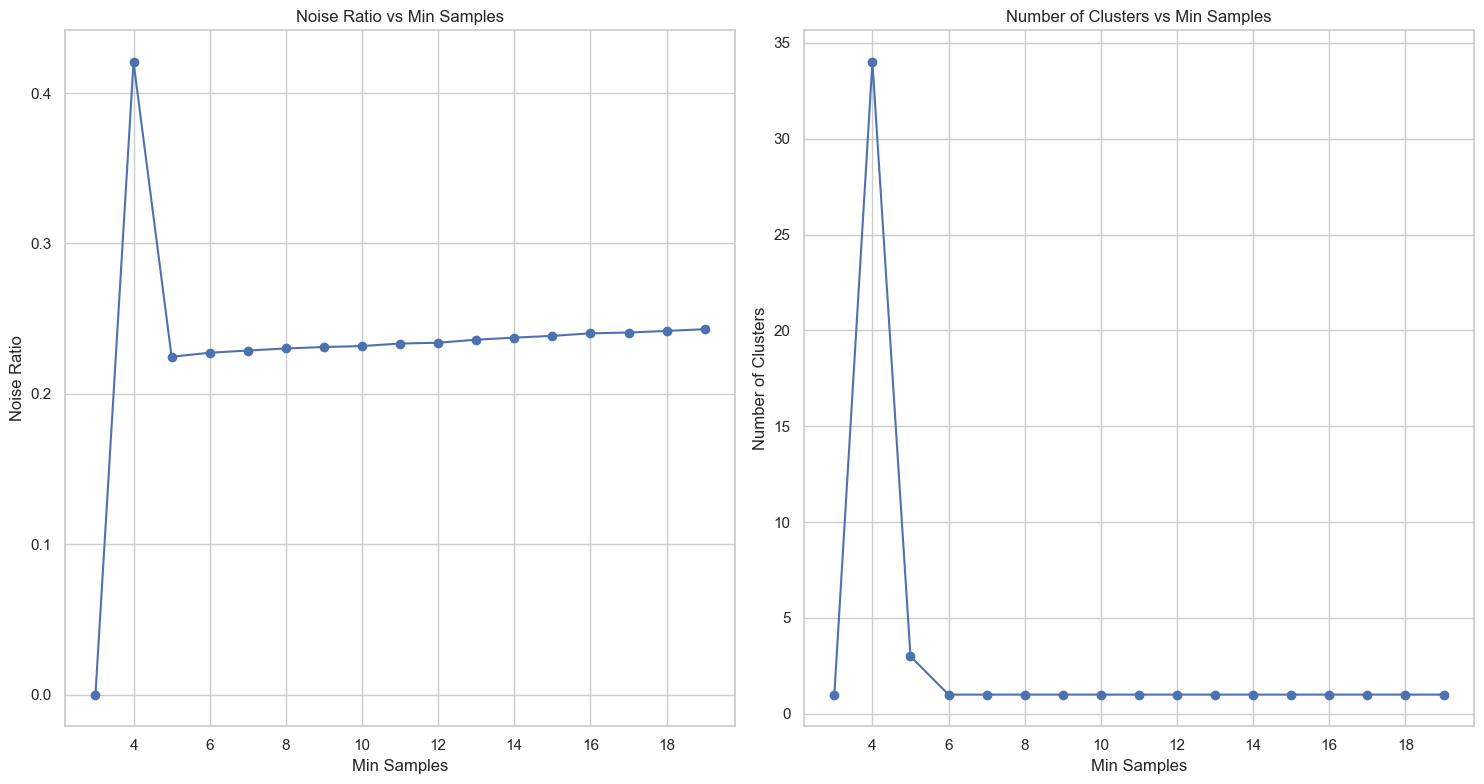

In [87]:
# Try different combinations and evaluate
results = []
best_noise_ratio = float('inf')
best_params = None
best_labels = None

for min_samples in min_samples_range:
    eps = eps_values[min_samples - min(min_samples_range)]
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.sum(labels == -1) / len(labels)
    
    results.append({
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio
    })
    
    if n_clusters > 1 and noise_ratio < best_noise_ratio:
        best_noise_ratio = noise_ratio
        best_params = (eps, min_samples)
        best_labels = labels

# Plot evaluation results
results_df = pd.DataFrame(results)
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(results_df['min_samples'], results_df['noise_ratio'], marker='o')
plt.title('Noise Ratio vs Min Samples')
plt.xlabel('Min Samples')
plt.ylabel('Noise Ratio')

plt.subplot(1, 2, 2)
plt.plot(results_df['min_samples'], results_df['n_clusters'], marker='o')
plt.title('Number of Clusters vs Min Samples')
plt.xlabel('Min Samples')
plt.ylabel('Number of Clusters')

plt.tight_layout()
plt.show()

## Analysis of Results

In [80]:
# Print clustering results
eps, min_samples = best_params
print(f"\nBest parameters: eps={eps:.3f}, min_samples={min_samples}")
print(f"Number of clusters: {len(set(best_labels)) - 1}")
print(f"Noise ratio: {best_noise_ratio:.3f}")

# Analyze outliers
outlier_indices = np.where(best_labels == -1)[0]
print(f"\nNumber of outliers: {len(outlier_indices)}")

print("\nAnalyzing top 5 outliers:")
for idx in outlier_indices[:5]:
    movie_id = data.index[idx]
    movie_features_present = [
        feature_mapping['id_to_feature'][int(col)] 
        for col in data.columns[data.iloc[idx] == 1]
    ]
    
    print(f"\nOutlier Movie: {movie_titles.get(movie_id, 'Unknown')}")
    print(f"Number of features: {len(movie_features_present)}")
    print("Features:")
    for feature in movie_features_present[:5]:
        print(f"  - {feature}")
    if len(movie_features_present) > 5:
        print(f"  ... and {len(movie_features_present) - 5} more features")



Best parameters: eps=1.414, min_samples=5
Number of clusters: 3
Noise ratio: 0.225

Number of outliers: 2122

Analyzing top 5 outliers:

Outlier Movie: Something's Gotta Give
Number of features: 9
Features:
  - Cast:Diane Keaton
  - Cast:Jack Nicholson
  - Cast:Keanu Reeves
  - Composer:Hans Zimmer
  - Decade:2000s
  ... and 4 more features

Outlier Movie: Richard III
Number of features: 7
Features:
  - Composer:Trevor Jones
  - Decade:1990s
  - Genre:Drama
  - Genre:Sci-Fi
  - Genre:War
  ... and 2 more features

Outlier Movie: Dragonheart
Number of features: 8
Features:
  - Cast:Dennis Quaid
  - Cast:Sean Connery
  - Composer:Randy Edelman
  - Decade:1990s
  - Genre:Action
  ... and 3 more features

Outlier Movie: Jingle All the Way
Number of features: 8
Features:
  - Cast:Arnold Schwarzenegger
  - Cast:Jim Belushi
  - Composer:David Newman
  - Decade:1990s
  - Genre:Adventure
  ... and 3 more features

Outlier Movie: Silkwood
Number of features: 9
Features:
  - Cast:Fred Ward
  - C

## Visualize Final Clustering Results

In [81]:
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(data)

plot_data = pd.DataFrame({
    'PC1': data_pca[:, 0],
    'PC2': data_pca[:, 1],
    'Cluster': best_labels.astype(str),
    'MovieID': data.index,
    'MovieName': [movie_titles.get(id, 'Unknown') for id in data.index]
})

plot_data['FeatureNames'] = plot_data['MovieID'].apply(get_feature_names)

# Create interactive plot
fig = px.scatter(
    plot_data,
    x='PC1',
    y='PC2',
    color='Cluster',
    hover_data={
        'MovieID': True,
        'MovieName': True,
        'FeatureNames': True,
        'Cluster': False,
        'PC1': False,
        'PC2': False
    },
    title=f'DBSCAN Clustering of Movies (eps={eps:.3f}, min_samples={min_samples})',
    width=800,
    height=600
)

fig.update_layout(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    legend_title='Cluster',
    legend=dict(itemsizing='constant')
)

fig.show()